# 1. Setup

## Import Dependencies

In [5]:
import cv2
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
import os
import glob
import uuid
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer, Dense, Input
from keras.metrics import Precision, Recall

The keras-vggface library provides three pre-trained VGGModels, a VGGFace1 model via model=’vgg16′ (the default), and two VGGFace2 models ‘resnet50‘ and ‘senet50‘.

The example below creates a ‘resnet50‘ VGGFace2 model and summarizes the shape of the expected inputs and outputs.

In [3]:
# create a vggface2 model
model = VGGFace(model='resnet50')
# summarize input and output expected shapes
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


## Set GPU Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures

In [4]:
#setup path
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

# 2. Collecting Positives and Anchors


## Collect Positive and Anchor Classes

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  # Cut down frame to 250x250px
  frame = frame[120:120+250, 200:200+250, :]

  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  cv2.imshow('Image Collection', frame)

  if cv2.waitKey(1) & 0XFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

## Data Augmentation

In [5]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)

    return data

In [6]:
exp_image = 'data/anchor/00b7e1f6-3140-11ee-9396-9c7bef1c47be.jpg'

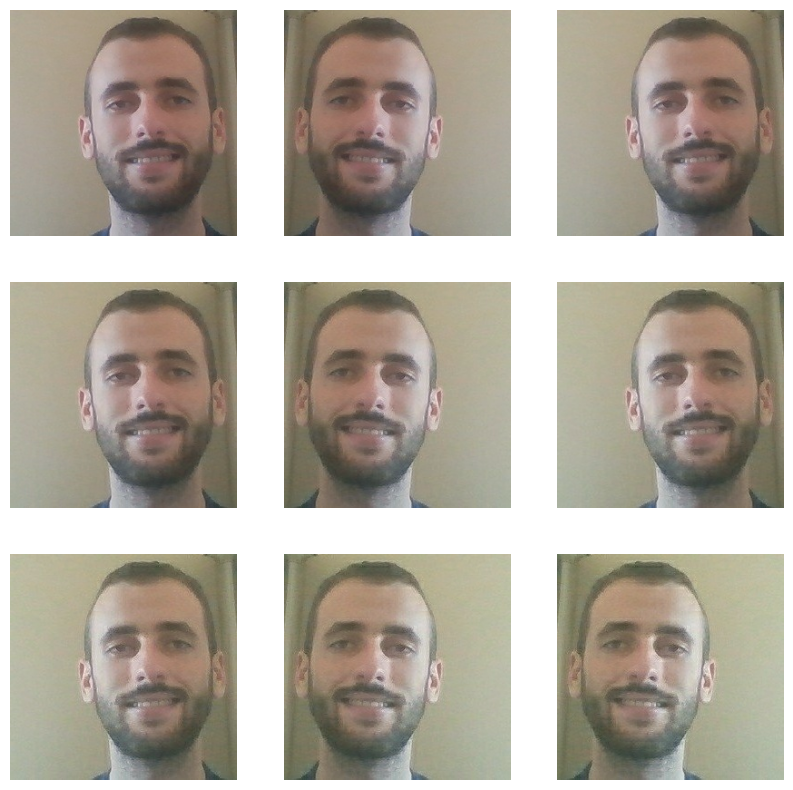

In [7]:
img = cv2.imread(exp_image)
augmented_images = data_aug(img)
num_images = len(augmented_images)
rows = 3
cols = 3

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(augmented_images[i][:,:,::-1])
    plt.axis('off')

plt.show()

In [ ]:
for file_name in tqdm(os.listdir(os.path.join(ANC_PATH))):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        #cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in tqdm(os.listdir(os.path.join(POS_PATH))):
  img_path = os.path.join(POS_PATH, file_name)
  img = cv2.imread(img_path)
  augmented_images = data_aug(img)

  for image in augmented_images:
      #cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Face Detection

## MTCNN

The MTCNN (Multi-Task Cascaded Convolutional Networks) algorithm is a deep learning-based face detection and alignment method that uses a cascading series of convolutional neural networks (CNNs) to detect and localize faces in digital images or videos. The algorithm is capable of detecting faces of different scales and orientations, and is robust to variations in lighting conditions, facial expressions, and occlusions.

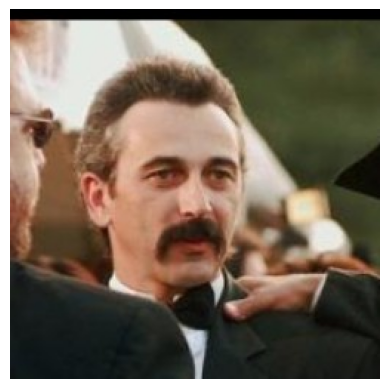

In [8]:
img = cv2.cvtColor(cv2.imread('data/negative/Aaron_Tippin_0001.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
detector = MTCNN()
faces = detector.detect_faces(img)
faces

1/1 [==============================] - 0s 218ms/step


[{'box': [69, 69, 87, 116],
  'confidence': 0.9999731779098511,
  'keypoints': {'left_eye': (105, 112),
   'right_eye': (142, 114),
   'nose': (129, 134),
   'mouth_left': (105, 157),
   'mouth_right': (138, 157)}}]

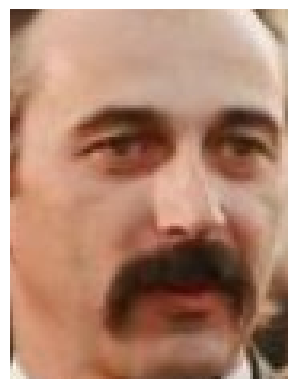

In [10]:
#fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
x1,y1,w,h = faces[0]['box']
x1, y1 = abs(x1), abs(y1)
x2 = abs(x1+w)
y2 = abs(y1+h)

#locate the co-ordinates of face in the image
store_face = img[y1:y2,x1:x2]
plt.imshow(store_face)
plt.axis('off')
plt.show()

In [6]:
def save_face(img_path, dest_folder):

  img = cv2.imread(img_path)
  detector = MTCNN()
  faces = detector.detect_faces(img)

  #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
  x1,y1,w,h = faces[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2 = abs(x1+w)
  y2 = abs(y1+h)

  #locate the co-ordinates of face in the image
  store_face = img[y1:y2,x1:x2]
  store_face = cv2.resize(store_face, (224, 224)) #The VGGFace model expects a 224x224x3 size face image as input, and it outputs a face embedding vector with a length of 2048.
  cv2.imwrite(os.path.join(dest_folder, os.path.basename(img_path)), store_face)

## Extract faces from our images

In [ ]:
images = glob.glob(os.path.join('data/anchor', '*.jpg'))

for img in tqdm(images):
    if os.path.isfile(os.path.join('data/anchor/faces', os.path.basename(img))):
      pass
    else:
      try:
        save_face(img, 'data/anchor/faces')
      except:
        pass

In [ ]:
images = glob.glob(os.path.join('data/positive', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('data/positive/faces', os.path.basename(img))):
    pass
  else:
    try:
      save_face(img, 'data/positive/faces')
    except:
      pass

In [ ]:
images = glob.glob(os.path.join('data/negative', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('data/negative/faces', os.path.basename(img))):
    pass
  else:
    try:
      save_face(img, 'data/negative/faces')
    except:
      pass

In [ ]:
images = glob.glob(os.path.join('application_data/verification_images', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('application_data/verification_images/faces', os.path.basename(img))):
    pass
  else:
    try:
      save_face(img, 'application_data/verification_images/faces')
    except:
      pass

In [12]:
print(len(os.listdir('data/anchor/faces')))
print(len(os.listdir('data/positive/faces')))
print(len(os.listdir('data/negative/faces')))

3001
2999
2979


# 4. Load and Preprocess Images

## Get Image Directories

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/faces/*.jpg').take(2900)
positive = tf.data.Dataset.list_files(POS_PATH+'/faces/*.jpg').take(2900)
negative = tf.data.Dataset.list_files(NEG_PATH+'/faces/*.jpg').take(2900)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\faces\\1c105ae4-3149-11ee-b1c4-7c10c984963b.jpg'

## Preprocessing

In [17]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

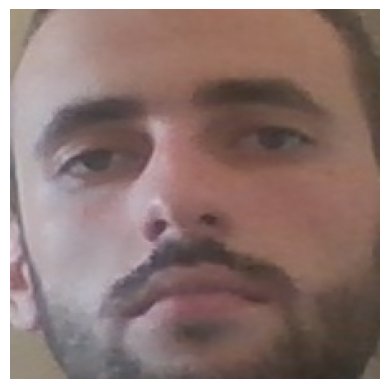

In [17]:
img = preprocess('data/anchor/faces/c428db57-313f-11ee-9025-9c7bef1c47be.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Create Labeled Dataset

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
samples = data.as_numpy_iterator()

In [35]:
example = samples.next()
example

(b'data\\anchor\\faces\\1bbb99e0-3149-11ee-adec-7c10c984963b.jpg',
 b'data\\positive\\faces\\329205d2-3149-11ee-b37b-7c10c984963b.jpg',
 1.0)

## Build Train and Test Partitions

In [18]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [37]:
res = preprocess_twin(*example)

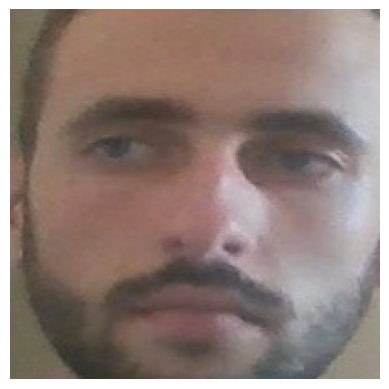

In [38]:
plt.imshow(res[0])
plt.axis('off')
plt.show()

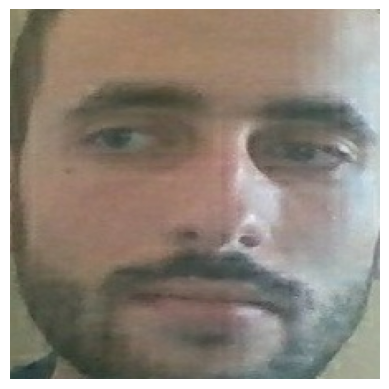

In [39]:
plt.imshow(res[1])
plt.axis('off')
plt.show()

In [40]:
res[2]

1.0

In [41]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [42]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [43]:
samples = data.as_numpy_iterator()

In [48]:
samp = samples.next()

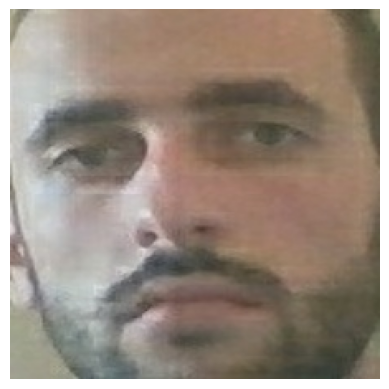

In [49]:
plt.imshow(samp[0])
plt.axis('off')
plt.show()

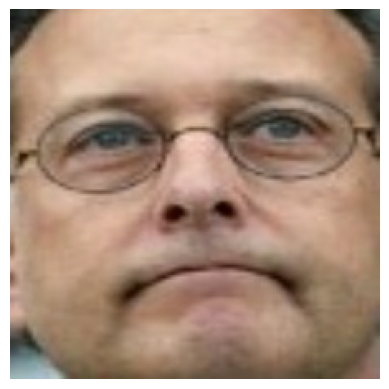

In [50]:
plt.imshow(samp[1])
plt.axis('off')
plt.show()

In [51]:
samp[2]

0.0

In [52]:
round(len(data)*.7)

4060

In [53]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [54]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None, None), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [55]:
round(len(data)*.3)

1740

In [56]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 5. Model Engineering

## Build Embedding Layer

In [8]:
def make_embedding():
    inp = Input(shape=(224,224,3), name='input_image')
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    d = base_model(inp)
    return Model(inputs=[inp], outputs=[d], name='embedding')

In [9]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vggface_resnet50 (Functiona  (None, 2048)             23561152  
 l)                                                              
                                                                 
Total params: 23,561,152
Trainable params: 23,508,032
Non-trainable params: 53,120
_________________________________________________________________


As seen, the vggface extaracts a feature vector of shape (2048,).

## Build Distance Layer

In [10]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## Make Siamese Model

In [11]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(224,224,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    d = Dense(512)(distances)
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(d)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [81]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 2048)         23561152    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 6. Training

## Setup Loss and Optimizer

In [82]:
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=True)

In [83]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

## Build Train Step Function

In [84]:
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    # Get anchor and positive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]

    # Forward pas
    yhat = siamese_model(X, training=True)

    # Calculate loss
    loss = binary_cross_loss(y,yhat)

  print(loss)

  # Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

## Build Training Loop

In [85]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(f'Epoch loss: {loss.numpy()} | Epoch recall : {r.result().numpy()} | Epoch precision : {p.result().numpy()}')

## Train the model

In [86]:
EPOCHS = 10

In [87]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
254/254 [==============================] - 122s 441ms/step
Epoch loss: 0.40827345848083496 | Epoch recall : 0.9945517778396606 | Epoch precision : 0.981907069683075

 Epoch 2/10
1/1 [==============================] - 0s 230ms/step


254/254 [==============================] - 107s 420ms/step
Epoch loss: 0.5665263533592224 | Epoch recall : 0.9467980265617371 | Epoch precision : 0.9384765625

 Epoch 3/10
1/1 [==============================] - 0s 256ms/step


254/254 [==============================] - 107s 421ms/step
Epoch loss: 0.47154736518859863 | Epoch recall : 0.9328358173370361 | Epoch precision : 0.8700696229934692

 Epoch 4/10
1/1 [==============================] - 0s 244ms/step


254/254 [==============================] - 107s 420ms/step
Epoch loss: 0.4082331359386444 | Epoch recall : 0.9717541933059692 | Epoch precision : 0.9944218993186951

 Epoch 5/10
1/1 [==============================] - 0s 248ms/step


254/254 [==============================] - 107s 422ms/step
Epoch loss: 0.47154736518859863 | Epoch recall : 0.9931034445762634 | Epoch precision : 1.0

 Epoch 6/10
 19/254 [=>............................] - ETA: 1:38

KeyboardInterrupt: 

In [95]:
# Save model
siamese_model.save('siamesemodel.h5')

In [12]:
# Load the model
siamese_model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [13]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 2048)         23561152    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 7. Evaluate Model

## Make predictions on a single batch

In [88]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [89]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 34ms/step


In [90]:
# Post-processing the results
y_pred = [1. if prediction > 0.5 else 0. for prediction in y_hat]
print(y_pred)

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]


In [91]:
print(list(y_true))

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]


## Evaluate on whole test set

In [92]:
# Evaluate on whole test set
r = Recall()
p = Precision()

recalls = []
precisions = []
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)
    recalls.append(r.result().numpy())
    precisions.append(p.result().numpy())

1/1 [==============================] - 0s 33ms/step


In [94]:
print('average test recall: ',sum(recalls)/len(recalls))
print('average test precision: ',sum(precisions)/len(precisions))

average test recall:  0.9951590507402333
average test precision:  1.0


# 8. Real Time Test

## Verification Function

In [14]:
def verify(model, detection_threshold, verification_threshold):
  results = []
  inp_img = 'application_data/input_image/input_image.jpg'
  verif_folder = 'application_data/verification_images/faces'
  for image in os.listdir(verif_folder):
    input_img = preprocess(inp_img)
    validation_img = preprocess(os.path.join(verif_folder,image))
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)
  detection = np.sum(np.array(results) > detection_threshold)
  verification = detection / len(os.listdir(verif_folder))
  verified = verification > verification_threshold
  return results, verified

## Test real time

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  cv2.imshow('Verification', frame)

  # Verification trigger
  if cv2.waitKey(10) & 0xFF == ord('v'):
    cv2.imwrite('application_data/input_image/input_image.jpg', frame)
    save_face('application_data/input_image/input_image.jpg', 'application_data/input_image')
    results, verified = verify(siamese_model, 0.8, 0.8)
    print(verified)

  if cv2.waitKey(10) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 85ms/step
True
1/1 [==============================] - 0s 72ms/step
False
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 76ms/step
False
1/1 [==============================] - 0s 76ms/step
True
